In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
%matplotlib inline

# Data preprocessing 
### paths to the folders

In [3]:
Train_path = 'train_data'
Valid_path = 'validation_data'
Test_path =  'test_data'

### Generate batches of tensor image data with real-time data augmentation.

In [5]:
#podzielenie zdjec na mniejsze serie(batch_size okresla rozmiar przesyłania zdjec)
#https://keras.io/preprocessing/image/
train_batches = ImageDataGenerator().flow_from_directory(Train_path, target_size=(224,224), classes=['dog','cat'],batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(Valid_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(Test_path, target_size=(224,224), classes=['dog','cat'], batch_size=10)

Found 200 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


### plots images with labels within jupyter notebook

In [6]:
# plots images with labels within jupyter notebook
# uint8	Unsigned integer (0 to 255), imshow-Display an image on the axes.
#https://docs.python.org/2/library/types.html
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [7]:
imgs,labels=next(train_batches)

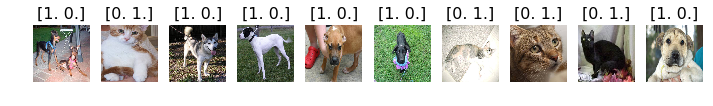

In [8]:
plots(imgs,titles=labels)

## Build and train model CNN
### Simple CNN model created by us. 

In [9]:
#Computes a 2-D convolution given 4-D input and filter #tensors.activation
#https://keras.io/layers/convolutional/
#statra i dokladnosc, optymalizator
#lr-Learning rate.
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(2, activation='softmax'),
    ])

## Adding optimalizator which is named 'Adam'.

In [10]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


### Trains the model on data generated batch-by-batch

In [12]:
#https://keras.io/models/sequential/
#batches of samples-steps_per_epoch
model.fit_generator(train_batches, steps_per_epoch=4,
                    validation_data=valid_batches, validation_steps=3, epochs=10, verbose=2)

Epoch 1/10
 - 3s - loss: 5.6420 - acc: 0.6500 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 2/10
 - 3s - loss: 6.0443 - acc: 0.6250 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 3/10
 - 3s - loss: 10.8797 - acc: 0.3250 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 4/10
 - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 5/10
 - 3s - loss: 8.4620 - acc: 0.4750 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 6/10
 - 4s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 7/10
 - 4s - loss: 6.4472 - acc: 0.6000 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 8/10
 - 3s - loss: 8.8650 - acc: 0.4500 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 9/10
 - 3s - loss: 8.8650 - acc: 0.4500 - val_loss: 7.5218 - val_acc: 0.5333
Epoch 10/10
 - 3s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.5218 - val_acc: 0.5333


### PREDICT DATA

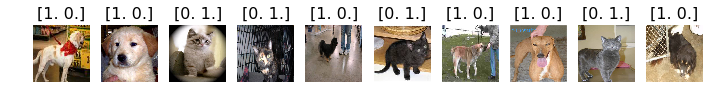

In [13]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [14]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 1., 0., 1., 1., 0., 1.], dtype=float32)

In [15]:
#generator,step-total number of steps/batches of samples dostraczana z generatora przed stop
predictions = model.predict_generator(test_batches,steps=1, verbose=0)

In [16]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### CONFUSION MATRIX-Compute to evaluate the accuracy of a classification

In [17]:
#test_labels-Ground truth (correct) target values.,predictions-estimated 
#target as returned by a classifier
cm = confusion_matrix(test_labels,predictions[:,0])

In [18]:
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#imshow-https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
#https://matplotlib.org/api/colorbar_api.html
#np.newaxis-the result gives a 2-d plot frame with x-axis from 0 to 1.
#itertools — Functions creating iterators for efficient looping
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 4]
 [0 6]]


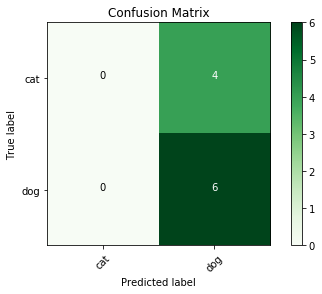

In [19]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Build VGG16 model

In [20]:
vgg16_model = keras.applications.vgg16.VGG16()

In [21]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
type(vgg16_model)

keras.engine.training.Model

In [23]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Transfer learning
Remove final layer of VGG and add our own, then train it.

In [25]:
model.layers.pop()

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
for layer in model.layers:
    layer.trainable = False

### Adding Dense Layer

In [28]:
model.add(Dense(2, activation='softmax'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Training VGG16 model

In [37]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit_generator(train_batches, steps_per_epoch=5, 
                    validation_data=valid_batches, validation_steps=5, epochs=10, verbose=2)

Epoch 1/15
 - 86s - loss: 0.3748 - acc: 0.9000 - val_loss: 0.4770 - val_acc: 0.8293
Epoch 2/15
 - 89s - loss: 0.3591 - acc: 0.9000 - val_loss: 0.4672 - val_acc: 0.8293
Epoch 3/15
 - 88s - loss: 0.4711 - acc: 0.8200 - val_loss: 0.3840 - val_acc: 0.8780
Epoch 4/15
 - 92s - loss: 0.3717 - acc: 0.8800 - val_loss: 0.3849 - val_acc: 0.8780
Epoch 5/15
 - 83s - loss: 0.3533 - acc: 0.9000 - val_loss: 0.3789 - val_acc: 0.8780
Epoch 6/15
 - 89s - loss: 0.3296 - acc: 0.9000 - val_loss: 0.3363 - val_acc: 0.9024
Epoch 7/15
 - 86s - loss: 0.3533 - acc: 0.8800 - val_loss: 0.4589 - val_acc: 0.8049
Epoch 8/15
 - 83s - loss: 0.3398 - acc: 0.8800 - val_loss: 0.4553 - val_acc: 0.8049
Epoch 9/15
 - 87s - loss: 0.4794 - acc: 0.7800 - val_loss: 0.4493 - val_acc: 0.8049
Epoch 10/15
 - 92s - loss: 0.3118 - acc: 0.9000 - val_loss: 0.4416 - val_acc: 0.8049
Epoch 11/15
 - 92s - loss: 0.3013 - acc: 0.8800 - val_loss: 0.3082 - val_acc: 0.9024
Epoch 12/15
 - 93s - loss: 0.2667 - acc: 0.9400 - val_loss: 0.3771 - val_a

### PREDICT VGG16 model

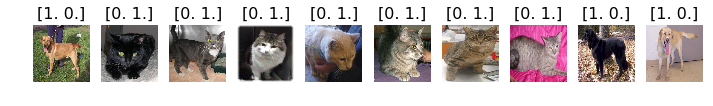

In [41]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [42]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1.], dtype=float32)

In [43]:
predictions = model.predict_generator(test_batches, steps=1,verbose=0)

In [44]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[2 5]
 [1 2]]


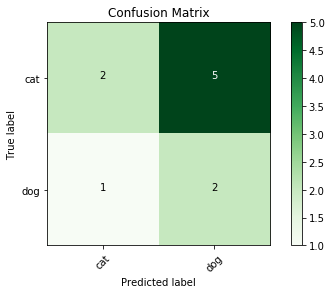

In [45]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')